# Gaussian Process for Time Series Forecasting

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
np.random.seed(1)

### Generate data

In [135]:
n = 300

X = np.linspace(0,100, n)
y = np.sin(X/2) + np.random.normal(0,0.3, n)

# Train/val/test split
train_rows = int(len(X)*0.7)
val_rows = train_rows + int(len(X)*0.2)

X_train = X[:train_rows].reshape((-1,1))
X_val = X[train_rows:val_rows].reshape((-1,1))
X_test = X[val_rows:].reshape((-1,1))

y_train = y[:train_rows]
y_val = y[train_rows:val_rows]
y_test = y[val_rows:]

Text(0, 0.5, 'Value')

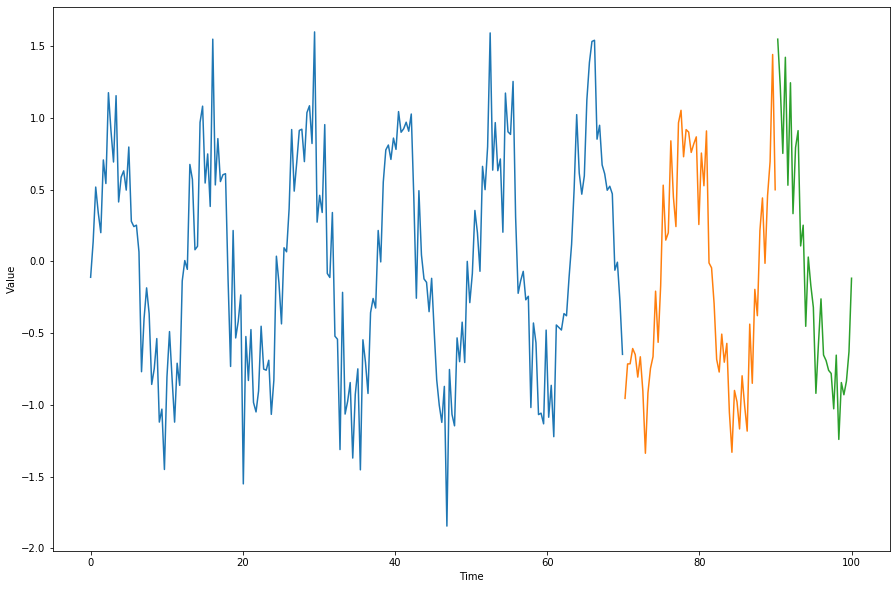

In [136]:
plt.figure(figsize=(15,10))

plt.plot(X_train, y_train)
plt.plot(X_val, y_val)
plt.plot(X_test, y_test)
plt.xlabel("Time")
plt.ylabel("Value")

### Covariance function
Most of the work involved in a Gaussian process lays within choosing a good covariance/kernel function. A periodic exponential sine squared component is good for modelling periodicity.

https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes

##### Constant kernel

##### Radial basis functions

##### Exponential sine squared

##### White kernel

For more info on kernels, see <a href ="https://www.cs.toronto.edu/~duvenaud/cookbook/">The Kernel Cookbook</a>, <a href ="http://www.gaussianprocess.org/gpml/chapters/RW4.pdf">Covariance Functions</a>, <a href="https://www.cs.cmu.edu/~epxing/Class/10708-15/notes/10708_scribe_lecture21.pdf">Advanced Gaussian Processes</a>, <a href="https://distill.pub/2019/visual-exploration-gaussian-processes/">A Visual Exploration of Gaussian Processes</a> or <a href="https://observablehq.com/@herbps10/gaussian-process-kernels">Gaussian Process Kernels</a>.

In [137]:
kernel = (ConstantKernel(2) 
          + ExpSineSquared(length_scale=5.0, periodicity_bounds=(1e-2, 1e2)) 
          + WhiteKernel(1))

### Train and visualise results
We use the validation data to inform our kernel/hyperparameter decisions. Once we are satisfied, we can evaluate the final model on the test data. The test data is *not* to be used for parameter optimisation!

In [138]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X_train, y_train)

y_pred, sigma = gp.predict(X_val, return_std=True)
y_pred_train, sigma_train = gp.predict(X_train, return_std=True)

Validation RMSE: 0.262076994197704
Validation PRMSE: 0.0943229784901849


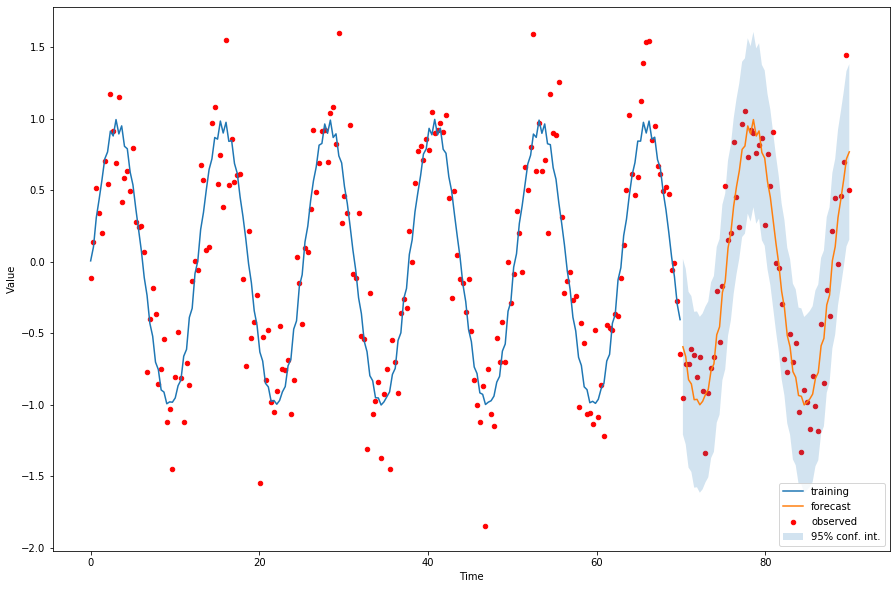

In [139]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE: {}".format(rmse))
print("Validation PRMSE: {}".format(rmse/(np.max(y_val)-np.min(y_val))))

# Plot the function, the prediction and the 95% confidence interval.
plt.figure(figsize=(15,10))
plt.scatter(X_train, y_train, c = 'red', alpha = 0.99, s = 20)
plt.plot(X_train, y_pred_train, label = "training")
plt.plot(X_val, y_pred, label = "forecast")
plt.scatter(X_val, y_val, label = "observed", c = 'red', alpha = 0.99, s = 20)
plt.fill_between(X_val.reshape(-1), y_pred - 1.97 * sigma, y_pred + 1.97 * sigma, alpha = 0.2, label = "95% conf. int.")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='lower right')

### Evaluate on test set
We need to merge the training and validation data, retrain the model and then make our forecast.

In [140]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

y_pred, sigma = gp.predict(X_test, return_std=True)

Test RMSE: 0.30919329976020854
Test PRMSE: 0.15459664988010427


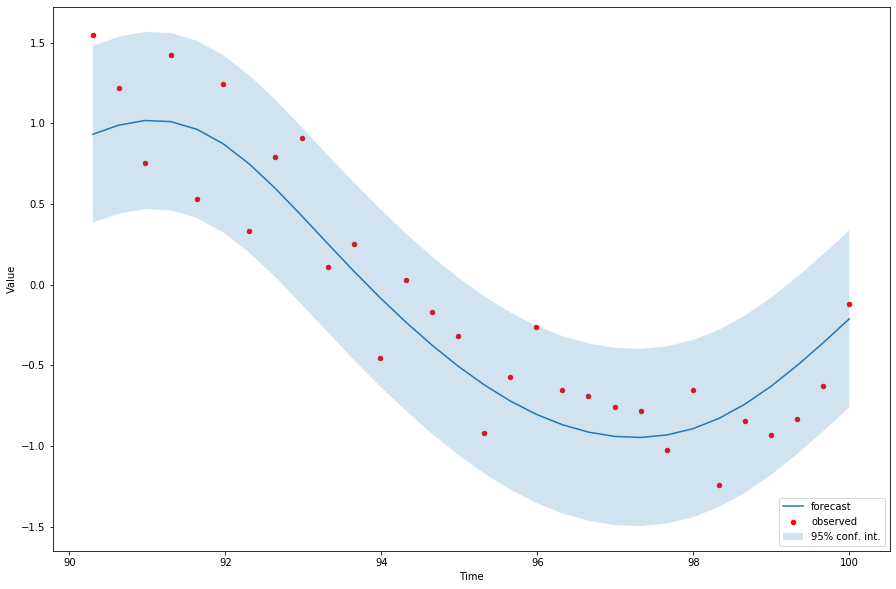

In [141]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: {}".format(rmse))
print("Test PRMSE: {}".format(rmse/2))

# Plot the function, the prediction and the 95% confidence interval.
plt.figure(figsize=(15,10))
plt.plot(X_test, y_pred, label = "forecast")
plt.scatter(X_test, y_test, label = "observed", c = 'red', alpha = 0.99, s = 20)
plt.fill_between(X_test.reshape(-1), y_pred - 1.97 * sigma, y_pred + 1.97 * sigma, alpha = 0.2, label = "95% conf. int.")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='lower right')